>> Run ours for arm on device 0 with seed 0 and 1000 steps.


steps:   0%|          | 0/1000 [00:00<?, ?it/s]

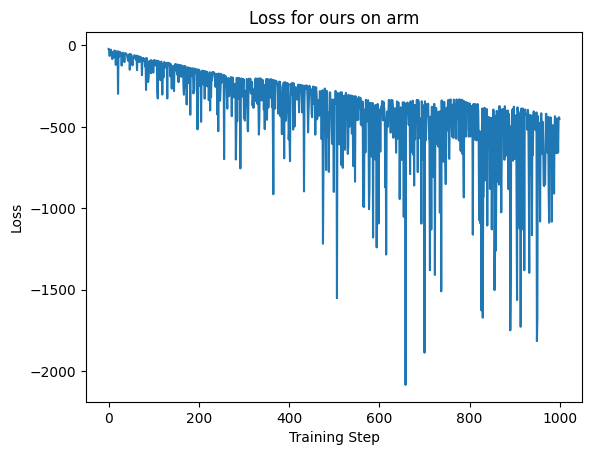

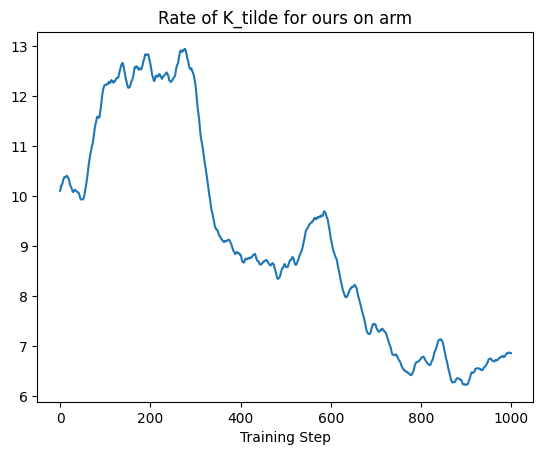

Mean of rate of K_tilde:  9.137414


In [7]:
import os
import sys
import argparse

sys.path.append("../")
sys.path.append("../../")
sys.dont_write_bytecode = True

import pyro
import torch
import numpy as np
import vectorized_loop as vec
from tqdm.auto import tqdm
from benchmark import arm

import util
import matplotlib.pyplot as plt


def run(args):
    util._TIMEIT = False
    methods = ["seq", "plate", "vmarkov", "discHMM", "ours"] if args.method == "all" else [args.method]

    for method in methods:
        pyro.clear_param_store()
        vec.clear_allocators()
        pyro.set_rng_seed(args.seed)

        if args.cuda >= 0:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(args.cuda)
        device = "cpu" if (not torch.cuda.is_available() or args.cuda == -1) else "cuda"
        torch.set_default_device(device)

        model = getattr(arm, f"model_{method}", None)
        svi = getattr(arm, f"svi_{method}", None)
        
        optim = arm.optim(args)
        data = arm.data(args)
        guide = arm.guide(model, *data)

        losses = []
        rate_K_tilde = []
        for step in (steps := tqdm(range(args.num_step), desc="steps", leave=True)):
            (loss, grads), _ = svi(model, guide, optim, *data)
            loss = loss / data[0].numel()
            losses.append(loss.detach().cpu().numpy())
            rate_K_tilde.append(pyro.get_param_store()["rate_K_tilde"].detach().cpu().numpy())
            steps.set_description("Seed: %d, Step: %d, Benchmark: %s, Method: %s, Loss: %.4f, rate: %.4f" % (args.seed, step, args.benchmark, method, loss, rate_K_tilde[-1]))
        losses = np.array(losses)
        rate_K_tilde = np.array(rate_K_tilde)

        plt.plot(losses)
        plt.title(f"Loss for {method} on {args.benchmark}")
        plt.xlabel("Training Step")
        plt.ylabel("Loss")
        plt.show()

        plt.plot(rate_K_tilde)
        plt.title(f"Rate of K_tilde for {method} on {args.benchmark}")
        plt.xlabel("Training Step")
        plt.show("rate_K_tilde")

        print("Mean of rate of K_tilde: ", np.mean(rate_K_tilde))


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--benchmark", type=str, default="arm")
    parser.add_argument("--method", type=str, default="ours")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--num_step", type=int, default=1000)
    parser.add_argument("--num_batch", type=int, default=None)
    parser.add_argument("--lr", type=float, default=1e-2)
    parser.add_argument("--cuda", type=int, default=0)
    args = parser.parse_args({})

    print(f">> Run {args.method} for {args.benchmark} on device {args.cuda} with seed {args.seed} and {args.num_step} steps.")
    run(args)

>> Run vmarkov for arm on device 0 with seed 0 and 1000 steps.


steps:   0%|          | 0/1000 [00:00<?, ?it/s]

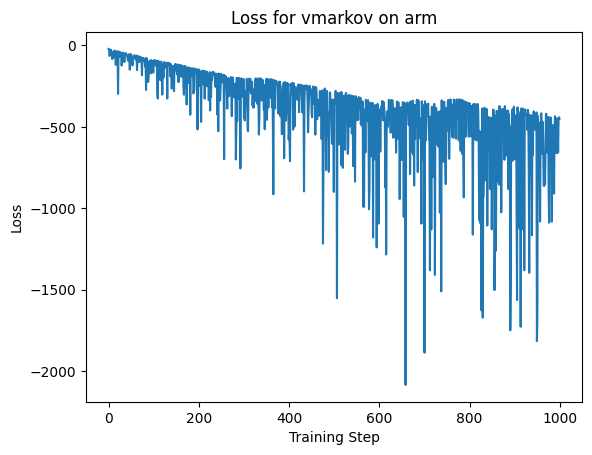

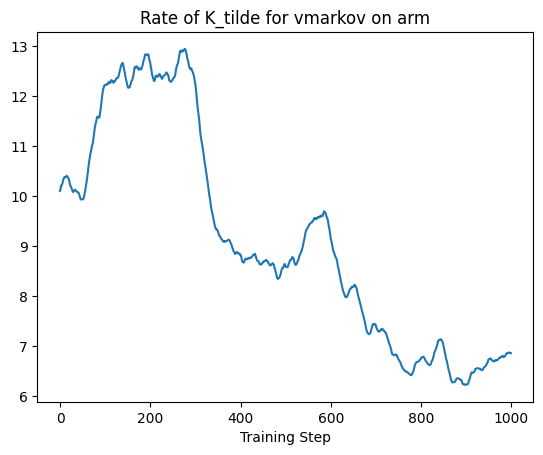

Mean of rate of K_tilde:  9.137414


In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--benchmark", type=str, default="arm")
    parser.add_argument("--method", type=str, default="vmarkov")
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--num_step", type=int, default=1000)
    parser.add_argument("--num_batch", type=int, default=None)
    parser.add_argument("--lr", type=float, default=1e-2)
    parser.add_argument("--cuda", type=int, default=0)
    args = parser.parse_args({})

    print(f">> Run {args.method} for {args.benchmark} on device {args.cuda} with seed {args.seed} and {args.num_step} steps.")
    run(args)